In [4]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

import datetime

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

In [5]:
data_path = './Datasets'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [6]:
train_y_df['time']+=1380
train = pd.concat([train_x_df, train_y_df], axis=0)
train = train.sort_values(by=['sample_id', 'time']).reset_index(drop=True)

In [7]:
train = train.iloc[:, :4].reset_index(drop=True)

In [21]:
sample_train = train.loc[train['sample_id'].isin(list(set(test_x_df['sample_id'].values)))]

In [25]:
# create dataset and dataloaders
max_encoder_length = 5
max_prediction_length = 120

training_cutoff = sample_train["time"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    sample_train[lambda x: x.time < training_cutoff],
    time_idx="time",
    target="open",
    categorical_encoders={"coins": NaNLabelEncoder().fit(sample_train.coin_index)},
    group_ids=["sample_id"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["open"],
    max_encoder_length=context_length,
    min_prediction_length=1,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, sample_train, min_prediction_idx=training_cutoff+1)

batch_size = 256
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

In [26]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

RuntimeError: Sizes of tensors must match except in dimension 0. Got 120 and 119 in dimension 1 (The offending index is 248)

In [11]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=1, gradient_clip_val=0.1)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 2.2 M 
-----------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.745     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at /home/yyeon/KeepGo/My-Competition-Struggle/Dacon/BitCoin/lr_find_temp_model.ckpt


suggested learning rate: 0.01445439770745928


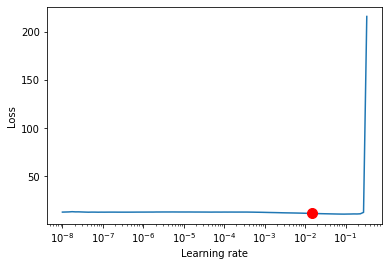

In [12]:
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-8)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [13]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=50,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=res.suggestion(),
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 2.2 M 
-----------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.745     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [14]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [15]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.0064)

In [20]:
sample_train.head()

,sample_id,time,coin_index,open
0,0,0,7,1.010004
1,0,1,7,1.009808
2,0,2,7,1.009808
3,0,3,7,1.010200
4,0,4,7,1.010985


In [18]:
x

{'encoder_cat': tensor([], size=(529, 256, 0), dtype=torch.int64),
 'encoder_cont': tensor([[[ 0.3460],
          [ 0.5996],
          [ 0.8529],
          ...,
          [ 0.0288],
          [ 0.2192],
          [ 0.0923]],
 
         [[ 0.4486],
          [ 0.4687],
          [ 0.4084],
          ...,
          [-0.8183],
          [-0.8233],
          [-0.5904]],
 
         [[ 0.5885],
          [ 1.7557],
          [ 1.8299],
          ...,
          [ 1.2255],
          [ 1.2467],
          [ 1.2573]],
 
         ...,
 
         [[ 0.6036],
          [ 0.4763],
          [ 0.4763],
          ...,
          [-0.5439],
          [-0.0971],
          [ 0.0304]],
 
         [[ 1.9195],
          [ 2.2296],
          [ 2.6720],
          ...,
          [-0.3491],
          [ 0.0079],
          [-0.0813]],
 
         [[ 2.2961],
          [ 1.7843],
          [ 0.7843],
          ...,
          [-0.2415],
          [ 0.1006],
          [-0.2171]]]),
 'encoder_target': tensor([[1.0008, 1

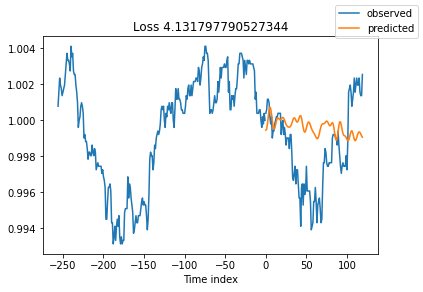

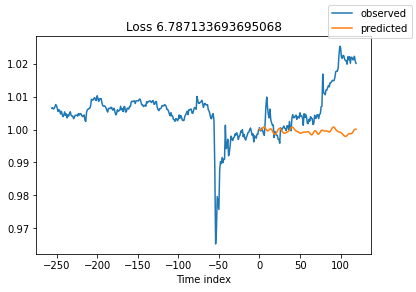

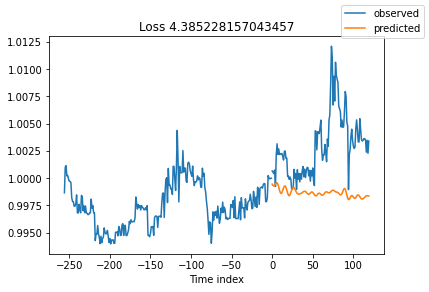

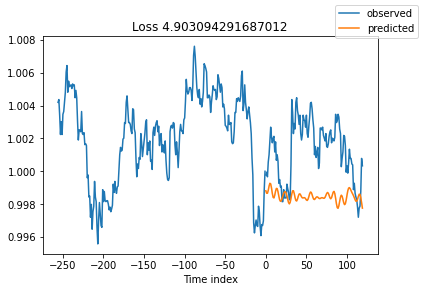

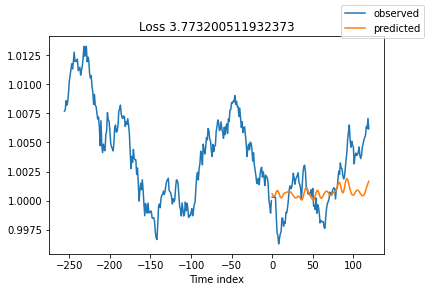

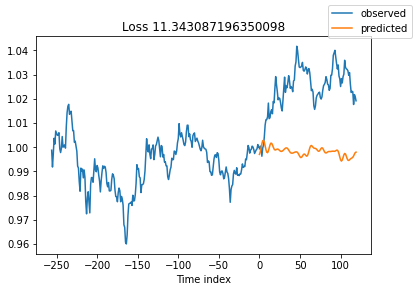

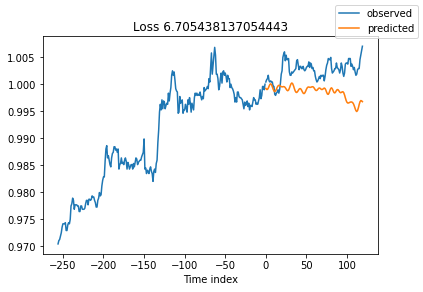

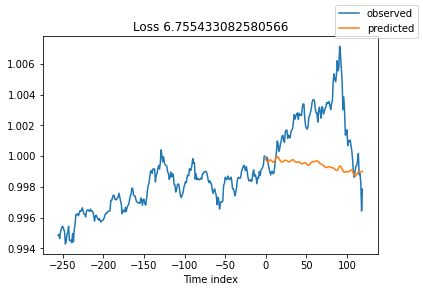

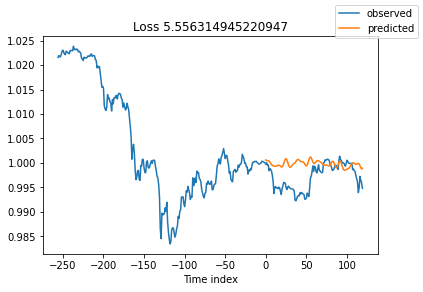

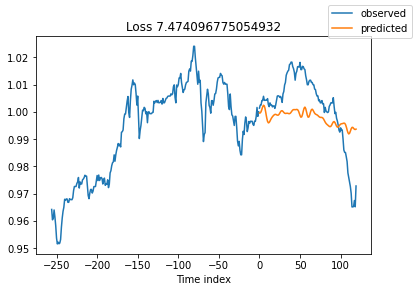

In [16]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")
test_x_df = test_x_df.iloc[:,:4]

# create dataset and dataloaders
max_encoder_length = 512
max_prediction_length = 120

training_cutoff = test_x_df["time"].max() - max_prediction_length

training = TimeSeriesDataSet(
    test_x_df[lambda x: x.time < training_cutoff],
    time_idx="time",
    target="open",
    categorical_encoders={"series": NaNLabelEncoder().fit(test_x_df.coin_index)},
    group_ids=["sample_id"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["open"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, test_x_df, min_prediction_idx=training_cutoff + 1)
batch_size = 128
test_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

In [ ]:
x,y = best_model.predict(test_dataloader, mode="prediction", return_x=True)

In [ ]:
x

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_model.predict(test_dataloader)
(actuals - predictions).abs().mean()

In [ ]:
predictions